# Statistical vs ML IDS — Wednesday DoS variants
Walk through a side-by-side build of a statistical detector (robust z-score) and an Isolation Forest on the CIC-IDS 2017 Wednesday DoS variants trace. We keep chronological order, fit only on benign windows to avoid leakage, and compare metrics/visuals/alerts on a held-out tail.


In [24]:
# for core implementation:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix

# for plotting & light pacing for demo output:
from matplotlib import pyplot as plt
import time

# for crisp (high-DPI) plots:
plt.rcParams["figure.dpi"] = 120

## Load data
Pull the Wednesday DoS CSV and sanity-check raw shape (rows, cols).


In [25]:
# load CIC-IDS 2017 Wednesday DoS flows
df = pd.read_csv("Wednesday-workingHours.pcap_ISCX.csv", low_memory=False) # low_memory=False prevents pandas from 
                                                                           # guessing dtypes inconsistently on large CSVs
# num of flow records & feature cols:
print("Raw rows, cols:", df.shape)

Raw rows, cols: (692703, 79)


## Timestamp, feature engineering, and selection
Normalize column names, attach a synthetic timestamp (10 ms spacing), derive packet/byte totals, and keep a compact slice focused on volume and TCP-flag activity.


In [26]:
# remove stray whitespace in col names:
df.columns = df.columns.str.strip()

# create synthetic monotonic timestamp index (10ms per flow) for resampling later:
df['Timestamp'] = pd.date_range(start="2017-07-07 15:00:00", periods=len(df), freq="10ms")
df = df.set_index('Timestamp')

# derived features - per-flow packet & byte totals:
df['packets'] = df['Total Fwd Packets'] + df['Total Backward Packets']
df['bytes']   = df['Total Length of Fwd Packets'] + df['Total Length of Bwd Packets']

# keep core DoS-relevant features:
keep = [
    # total number of packets & bytes in each flow (calculated above):
    'packets',
    'bytes',

    # service targeted by the flow (attacks concentrate on specific ports):
    'Destination Port',

    # average packet size (slow-rate attacks use tiny packets; volumetric use large bursts):
    'Packet Length Mean',
    
    # variability of packet sizes (legit traffic varies; floods are often uniform or extremely noisy):
    'Packet Length Std',
    'Packet Length Variance',

    # smallest and largest packet seen (indicates payload structure or amplification behaviors):
    'Min Packet Length', 
    'Max Packet Length',

    # TCP handshake flags (imbalances reveal SYN floods / connection exhaustion):
    'SYN Flag Count', 
    'ACK Flag Count',

    # teardown/reset behavior (attacks rarely close cleanly; RST spikes indicate instability):
    'FIN Flag Count', 
    'RST Flag Count',

    # urgent payload push (abused in low-rate DoS patterns)
    'PSH Flag Count', 

    # congestion signaling echo (rare in normal flows; spikes during saturations):
    'ECE Flag Count',

    # packet directionality (DoS floods are forward-heavy and see weak replies):
    'Subflow Fwd Packets', 
    'Subflow Bwd Packets',

    # dataset-provided ground truth (used only for eval):
    'Label'
]

# only keep the above features in the df:
df = df[keep]

df.head()

,packets,bytes,Destination Port,Packet Length Mean,Packet Length Std,Packet Length Variance,Min Packet Length,Max Packet Length,SYN Flag Count,ACK Flag Count,FIN Flag Count,RST Flag Count,PSH Flag Count,ECE Flag Count,Subflow Fwd Packets,Subflow Bwd Packets,Label
Timestamp,,,,,,,,,,,,,,,,,
2017-07-07 15:00:00.000,2,12,80,6.000000,0.000000,0.000000,6,6,0,1,0,0,0,0,1,1,BENIGN
2017-07-07 15:00:00.010,16,498,389,29.294118,56.529599,3195.595588,0,163,0,0,0,0,1,0,11,5,BENIGN
2017-07-07 15:00:00.020,16,6300,88,370.588235,671.751541,451250.132400,0,1575,0,0,0,0,1,0,10,6,BENIGN
2017-07-07 15:00:00.030,29,10112,389,337.066667,704.654082,496537.374700,0,3069,0,0,0,0,1,0,17,12,BENIGN
2017-07-07 15:00:00.040,15,6302,88,393.875000,704.585067,496440.116700,0,1576,0,0,0,0,1,0,9,6,BENIGN


## Aggregate into 5s windows and derive ground truth

Using 5s windows smooths burstiness while staying near-real-time. A window is marked attack when >50% of its flows are non-BENIGN.


In [27]:
# aggregate flows into 5-second windows to smooth bursty traffic 
# (sum volume features, average size features, & count unique destination ports):
agg = df.resample("5s").agg({
    'packets':'sum', 'bytes':'sum', 
    'Destination Port':'nunique',
    'Packet Length Mean':'mean', 
    'Packet Length Std':'mean', 'Packet Length Variance':'mean',
    'Min Packet Length':'mean', 'Max Packet Length':'mean',
    'SYN Flag Count':'sum', 'ACK Flag Count':'sum', 
    'FIN Flag Count':'sum', 'RST Flag Count':'sum', 
    'PSH Flag Count':'sum', 
    'ECE Flag Count':'sum',
    'Subflow Fwd Packets':'sum', 'Subflow Bwd Packets':'sum',
    
    # fraction of flows that are labelled non-benign:
    'Label': lambda x: (x != 'BENIGN').mean()
})

# mark a window as attack if a majority of its flows are non-benign:
agg['is_attack'] = (agg['Label'] > 0.5).astype(int)

# drop the label (never used for training, only eval):
agg = agg.drop(columns=['Label'])

# replace infinities & missing values created by resampling:
agg = agg.replace([np.inf, -np.inf], np.nan).fillna(0)

# see class balance:
print(agg[['is_attack']].value_counts(normalize=True, dropna=False))

is_attack
0            0.630592
1            0.369408
Name: proportion, dtype: float64


## Train/test split without temporal leakage
Keep chronological order. Start the test set at the last 20% of attack-labelled windows so the tail contains positives, and fit both detectors only on benign training windows to avoid leakage.


In [28]:
# identify windows labeled as attacks (used only to anchor the split):
attack_windows = agg.index[agg['is_attack'] == 1]
if len(attack_windows) == 0:
    raise ValueError("No attack-labelled windows found; cannot build split")

# start the test set at the last 20% of attack windows to ensure the tail contains positives:
test_start = attack_windows[int(len(attack_windows) * 0.8)]
train = agg.loc[:test_start - pd.Timedelta(seconds=5)]
test = agg.loc[test_start:]

# models are fit only on benign training windows to prevent label leakage:
benign_train = train[train['is_attack'] == 0].copy()
print(
    f"Windows train={len(train)}, test={len(test)}, "
    f"train_attacks={train['is_attack'].sum()}, test_attacks={test['is_attack'].sum()}, "
    f"benign_for_fit={len(benign_train)}"
)

Windows train=545, test=841, train_attacks=409, test_attacks=103, benign_for_fit=136


## Statistical baseline: robust z-score
Use packet/byte/size + SYN/ACK features. Compute mean/std on benign-only windows; flag anomalies when the summed absolute z-score exceeds the 99th percentile of benign windows (tune the quantile for the recall/precision trade-off).


In [29]:
# features used in the z-score detector (volume + size + handshake imbalance):
Z_COLS = [
    'packets', 'bytes',
    'Packet Length Mean', 'Packet Length Std',
    'SYN Flag Count', 'ACK Flag Count'
]

# benign baseline mean:
train_mean = benign_train[Z_COLS].mean()

# replace zero std to avoid division-by-zero:
train_std = benign_train[Z_COLS].std(ddof=0).replace(0, 1)

# sum absolute z-scores across dimensions to get a single anomaly score per window:
agg['z_score'] = ((agg[Z_COLS] - train_mean) / train_std).abs().sum(axis=1)

# threshold picked from benign-only distribution (99th percentile) to keep false positives low:
z_threshold = agg.loc[benign_train.index, 'z_score'].quantile(0.99)
agg['z_anomaly'] = (agg['z_score'] > z_threshold).astype(int)

## ML baseline: Isolation Forest (fit on benign windows)
Standardize features so no single dimension dominates. Train on benign windows only; contamination≈0.02 controls how many points are treated as anomalies (higher = more recall/FP). n_estimators=300 for stability.


In [30]:
# cols used for the IF detector (volume + size + TCP flags):
dos_features = [
    'packets', 'bytes', 
    'Packet Length Mean', 'Packet Length Std',
    'SYN Flag Count', 'ACK Flag Count', 'FIN Flag Count', 'RST Flag Count'
]  # feature vector for the ML baseline

scaler = StandardScaler()

# standardize benign training windows:
X_train = scaler.fit_transform(benign_train[dos_features])

iso = IsolationForest(
    contamination=0.02,  # expected anomaly rate; higher --> more sensitive / more FPs
    n_estimators=300,    # number of trees (stability)
    max_samples='auto',  # subsample automatically for each tree
    random_state=42,
    n_jobs=-1
)
iso.fit(X_train)

# run detector on all windows:
agg['if_anomaly'] = iso.predict(scaler.transform(agg[dos_features]))

# convert to 0/1 anomalies:
agg['if_anomaly'] = (agg['if_anomaly'] == -1).astype(int)

## Evaluation on held-out test tail
Report precision, recall, and F1 on the chronological test tail only.


In [31]:
# evaluate model predictions on the held-out test window:
def evaluate(name: str, column: str):
    y_true = test['is_attack']  # ground-truth attack labels:
    y_pred = agg.loc[test.index, column]  # model predictions for the same time index
    
    print(f"=== {name} (test) ===")
    print(classification_report(y_true, y_pred, digits=3, zero_division=0))
    
    # return core metrics for quick comparison:
    return {
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }

# keep metrics handy for later comparison or plotting:
metrics = {
    'zscore': evaluate('Z-score', 'z_anomaly'),
    'isolation_forest': evaluate('Isolation Forest', 'if_anomaly')
}

=== Z-score (test) ===
              precision    recall  f1-score   support

           0      0.944     1.000     0.971       738
           1      1.000     0.573     0.728       103

    accuracy                          0.948       841
   macro avg      0.972     0.786     0.850       841
weighted avg      0.951     0.948     0.941       841

=== Isolation Forest (test) ===
              precision    recall  f1-score   support

           0      0.941     1.000     0.970       738
           1      1.000     0.553     0.713       103

    accuracy                          0.945       841
   macro avg      0.971     0.777     0.841       841
weighted avg      0.949     0.945     0.938       841



In [32]:
# display confusion matrix w/ explicit TN/FP/FN/TP counts:
def show_cm(name: str, column: str):
    y_true = test['is_attack']
    y_pred = agg.loc[test.index, column]
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"\n=== {name} confusion matrix (test) ===")
    print(cm)
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

show_cm("Z-score", "z_anomaly")
show_cm("Isolation Forest", "if_anomaly")


=== Z-score confusion matrix (test) ===
[[738   0]
 [ 44  59]]
TN=738, FP=0, FN=44, TP=59

=== Isolation Forest confusion matrix (test) ===
[[738   0]
 [ 46  57]]
TN=738, FP=0, FN=46, TP=57


## Visualize detections
Yellow band marks the test window; red dots = z-score anomalies; blue x = Isolation Forest anomalies.


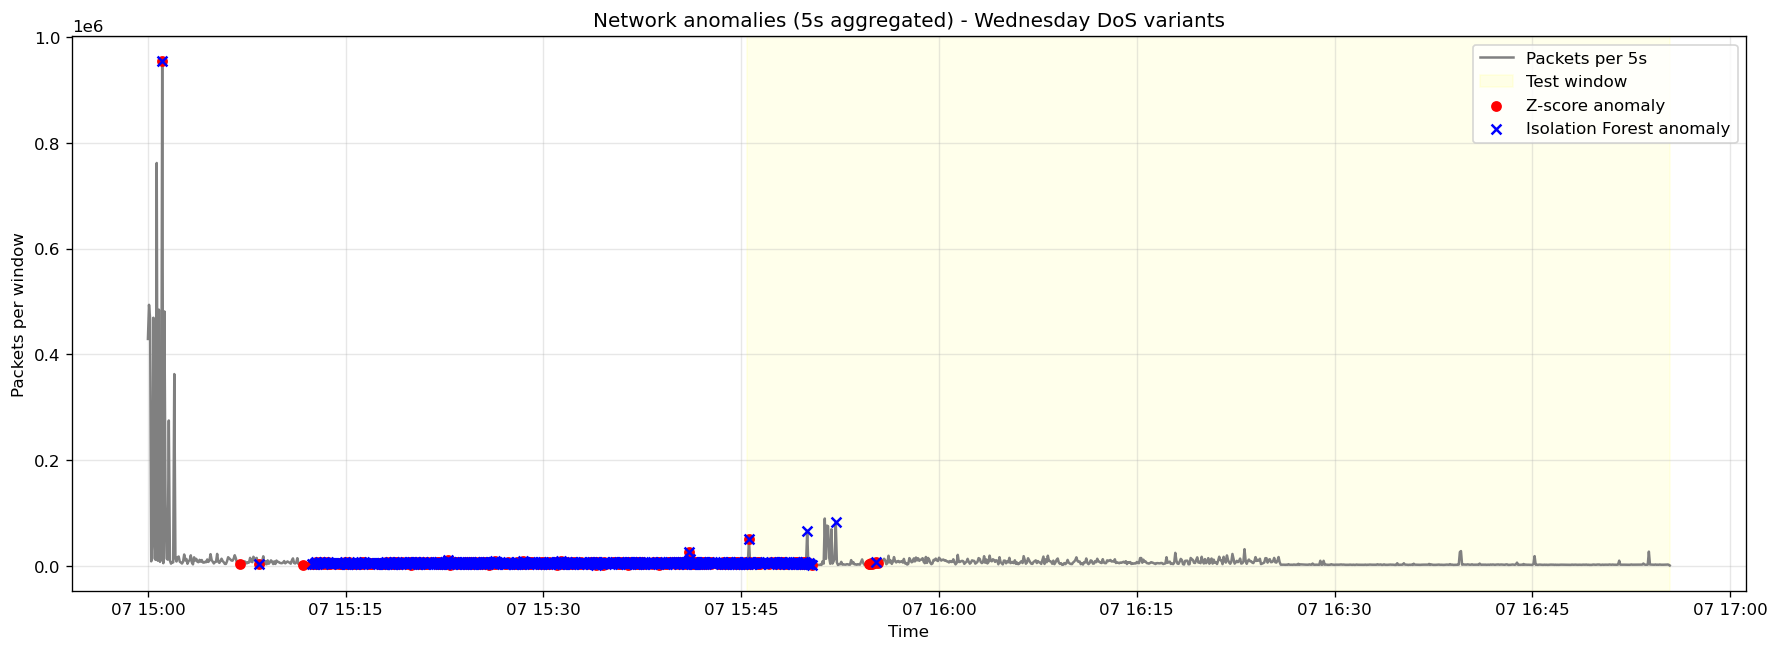

In [33]:
# packet volume over time w/ test segment highlighted:
plt.figure(figsize=(18, 6))
plt.plot(agg.index, agg['packets'], color='grey', label='Packets per 5s')
plt.axvspan(test.index[0], test.index[-1], color='yellow', alpha=0.08, label='Test window')

# plot anomaly markers for each detector:
plt.scatter(agg.index[agg['z_anomaly'] == 1], agg['packets'][agg['z_anomaly'] == 1],
            color='red', s=30, label='Z-score anomaly', zorder=3)
plt.scatter(agg.index[agg['if_anomaly'] == 1], agg['packets'][agg['if_anomaly'] == 1],
            color='blue', s=35, marker='x', label='Isolation Forest anomaly', zorder=4)

plt.title("Network anomalies (5s aggregated) - Wednesday DoS variants")
plt.xlabel("Time")
plt.ylabel("Packets per window")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Streaming-style alerts
Print lightweight alerts for any window the detectors flag, mimicking a streaming pipeline.


In [34]:
print("=== Real-time style alerts (prints only detected windows) ===")

# iterate through windows & emit alerts for any anomalies:
for ts, row in agg.iterrows():
    if row['if_anomaly'] or row['z_anomaly']:
        print(
            f"[ALERT] {ts} | packets={row['packets']} | ports={row['Destination Port']} | "
            f"SYN={row['SYN Flag Count']} | attack={row['is_attack']} | IF={row['if_anomaly']} | Z={row['z_anomaly']}"
        )

        # small pause to keep the streaming output readable in demos:
        time.sleep(0.03)

=== Real-time style alerts (prints only detected windows) ===
[ALERT] 2017-07-07 15:01:05 | packets=954045.0 | ports=76.0 | SYN=37.0 | attack=0.0 | IF=1.0 | Z=1.0
[ALERT] 2017-07-07 15:07:00 | packets=3264.0 | ports=107.0 | SYN=321.0 | attack=1.0 | IF=0.0 | Z=1.0
[ALERT] 2017-07-07 15:08:25 | packets=4189.0 | ports=139.0 | SYN=237.0 | attack=1.0 | IF=1.0 | Z=1.0
[ALERT] 2017-07-07 15:11:45 | packets=2561.0 | ports=5.0 | SYN=280.0 | attack=1.0 | IF=0.0 | Z=1.0
[ALERT] 2017-07-07 15:12:25 | packets=2723.0 | ports=1.0 | SYN=145.0 | attack=1.0 | IF=1.0 | Z=1.0
[ALERT] 2017-07-07 15:12:30 | packets=3532.0 | ports=3.0 | SYN=0.0 | attack=1.0 | IF=0.0 | Z=1.0
[ALERT] 2017-07-07 15:12:35 | packets=4054.0 | ports=1.0 | SYN=0.0 | attack=1.0 | IF=1.0 | Z=1.0
[ALERT] 2017-07-07 15:12:40 | packets=6142.0 | ports=1.0 | SYN=0.0 | attack=1.0 | IF=1.0 | Z=1.0
[ALERT] 2017-07-07 15:12:45 | packets=6586.0 | ports=2.0 | SYN=0.0 | attack=1.0 | IF=1.0 | Z=1.0
[ALERT] 2017-07-07 15:12:50 | packets=3518.0 | po